In [20]:
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
import pandas as pd
import torch
import h5py
from dataset.MatDataset import JHTDB_RECTANGULAR, JHTDB_RECTANGULAR_BOUNDARY
from models.encoder import *
from models.classifier import *

: 

In [21]:
dataset = JHTDB_RECTANGULAR_BOUNDARY(root='data/jhtdb_transition_bc', tstart=1, tend=10, fields='u', dataset='transition_bl', partition=True, sub_size=14)
full_sample_ = dataset.get_one_full_sample(100)

c:\Work\ARRS\dataset\MatDataset.py:623: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(os.path.join(self.root, 'processed', 'data.pt'))


In [22]:
full_sample = full_sample_[1]
full_sample_recon = full_sample_[0]


In [35]:
idx1 = 30
idx2 = 1500
idx3 = 1800
sub_sample_0 = full_sample[idx1][:, :, 0].squeeze()
sub_sample_1 = full_sample[idx2][:, :, 0].squeeze()
sub_sample_2 = full_sample[idx3][:, :, 0].squeeze()

num_partiton_dim_x = full_sample_recon.shape[1] // sub_sample_0.shape[1] 
num_partiton_dim_y = full_sample_recon.shape[0] // sub_sample_0.shape[1] 
print(num_partiton_dim_x, num_partiton_dim_y)

207 13


(0.0, 17.0, 0.0, 17.0)

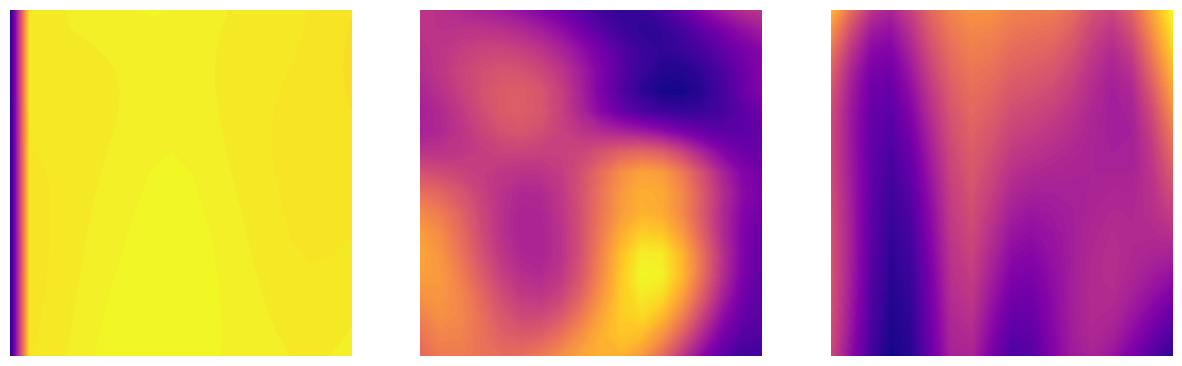

In [40]:

fig, ax = plt.subplots(1, 3, figsize=(15, 4.5))
ax[0].contourf(sub_sample_0, levels=100, cmap='plasma')
ax[0].axis('off')
ax[1].contourf(sub_sample_1, levels=100, cmap='plasma')
ax[1].axis('off')

ax[2].contourf(sub_sample_2, levels=100, cmap='plasma' )
ax[2].axis('off')

(64, 32) (80, 1840) (96, 2208)


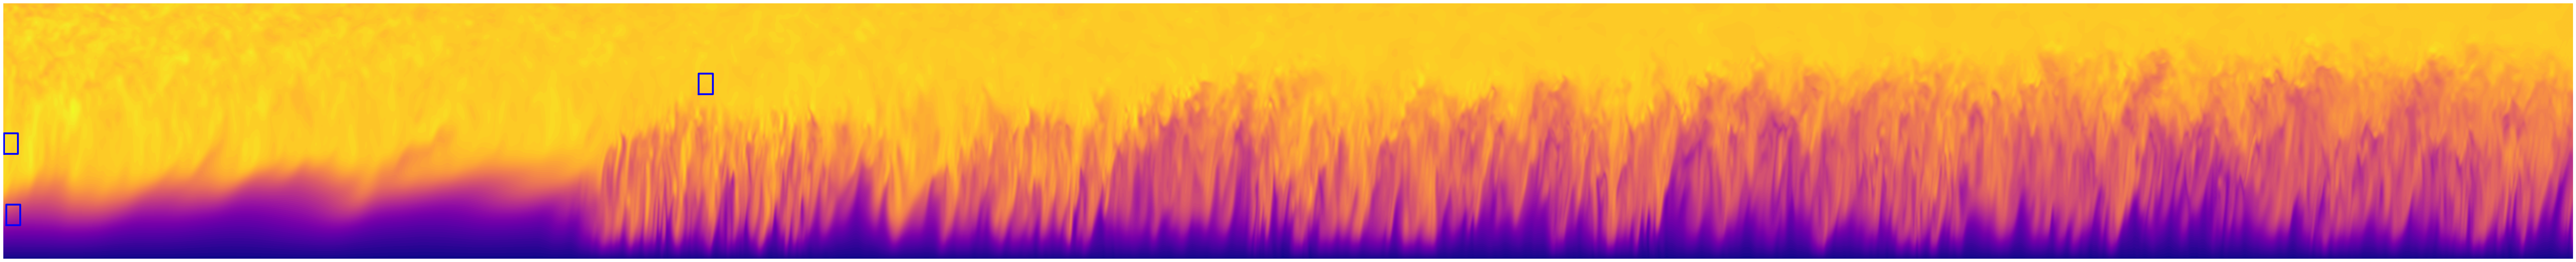

In [37]:
# plot the full sample with red box marking the sub sample location
plt.figure(figsize=(100, 10))
plt.contourf(full_sample_recon.squeeze(), levels=100, cmap='plasma')
plt.axis('off')
sample_0_loc = (idx1 % num_partiton_dim_y, idx1 // num_partiton_dim_y)
sample_1_loc = (idx2 % num_partiton_dim_y, idx2 // num_partiton_dim_y)
sample_2_loc = (idx3 % num_partiton_dim_y, idx3 // num_partiton_dim_y)
print(sample_0_loc, sample_1_loc, sample_2_loc)

# reverse y axis dur to the way the image is plotted
# sample_0_loc = (full_sample_recon.shape[0] - sample_0_loc[0] - sub_sample_0.shape[0], sample_0_loc[1])
# sample_1_loc = (full_sample_recon.shape[0] - sample_1_loc[0] - sub_sample_1.shape[0], sample_1_loc[1])
# sample_2_loc = (full_sample_recon.shape[0] - sample_2_loc[0] - sub_sample_2.shape[0], sample_2_loc[1])


plt.plot([sample_0_loc[1], sample_0_loc[1] + sub_sample_0.shape[1], sample_0_loc[1] + sub_sample_0.shape[1], sample_0_loc[1], sample_0_loc[1]], [sample_0_loc[0], sample_0_loc[0], sample_0_loc[0] + sub_sample_0.shape[0], sample_0_loc[0] + sub_sample_0.shape[0], sample_0_loc[0]], 'b', linewidth=4)
plt.plot([sample_1_loc[1], sample_1_loc[1] + sub_sample_1.shape[1], sample_1_loc[1] + sub_sample_1.shape[1], sample_1_loc[1], sample_1_loc[1]], [sample_1_loc[0], sample_1_loc[0], sample_1_loc[0] + sub_sample_1.shape[0], sample_1_loc[0] + sub_sample_1.shape[0], sample_1_loc[0]], 'b', linewidth=4)
plt.plot([sample_2_loc[1], sample_2_loc[1] + sub_sample_2.shape[1], sample_2_loc[1] + sub_sample_2.shape[1], sample_2_loc[1], sample_2_loc[1]], [sample_2_loc[0], sample_2_loc[0], sample_2_loc[0] + sub_sample_2.shape[0], sample_2_loc[0] + sub_sample_2.shape[0], sample_2_loc[0]], 'b', linewidth=4) 


In [26]:
from models.encoder import SpectrumEncoder

encoder = SpectrumEncoder(n_components=10, domain_size=14)
tke_spectrum_0 = encoder._compute_tke_spectrum([sub_sample_0, 0.1963495, 0.1963495])
tke_spectrum_1 = encoder._compute_tke_spectrum([sub_sample_1, 0.1963495, 0.1963495])
tke_spectrum_2 = encoder._compute_tke_spectrum([sub_sample_2, 0.1963495, 0.1963495])

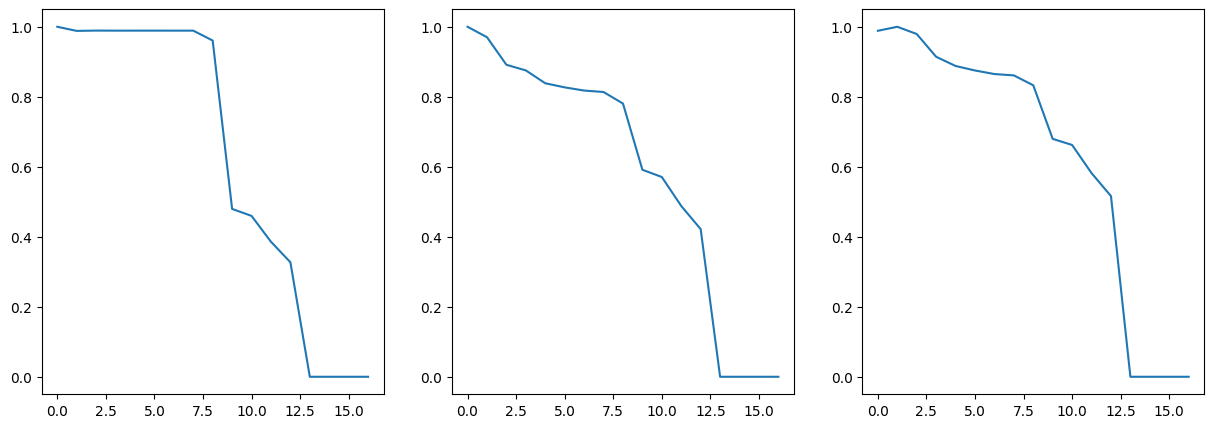

In [27]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].plot(tke_spectrum_0)
ax[1].plot(tke_spectrum_1)
ax[2].plot(tke_spectrum_2)

In [28]:
latent_space = encoder.get_latent_space(full_sample)
print(np.max(latent_space), np.min(latent_space))
classifier2 = KMeansClassifier(n_clusters=3)
classifier2.train(latent_space)
pred = classifier2.cluster(latent_space)
print(pred[idx1], pred[idx2], pred[idx3])

1.0 0.0
0 2 2


In [ ]:

classifier = KMeansWasserstein(n_clusters=3)
classifier.fit(latent_space)
pred = classifier.predict(latent_space)
print(pred[idx1], pred[idx2], pred[idx3])


1 2 2


309427 288431 96402


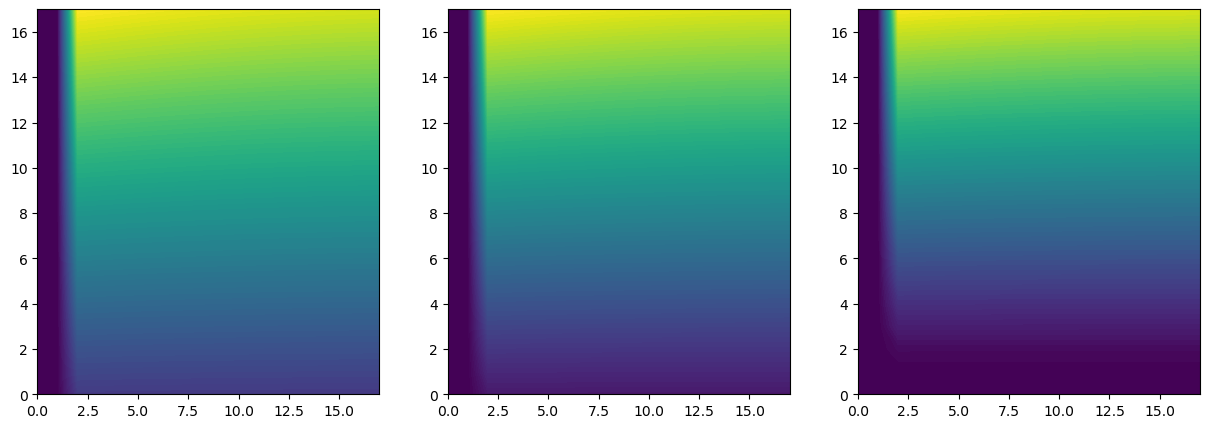

In [ ]:
# locate label 1 samples and label 2 samples
label_0_loc = np.where(pred == 0)
label_1_loc = np.where(pred == 1)
label_2_loc = np.where(pred == 2)

print(len(label_0_loc[0]), len(label_1_loc[0]), len(label_2_loc[0]))

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].contourf(full_sample[label_0_loc[0][0]].squeeze(), levels=100, cmap='viridis')
ax[1].contourf(full_sample[label_1_loc[0][0]].squeeze(), levels=100, cmap='viridis')
ax[2].contourf(full_sample[label_2_loc[0][0]].squeeze(), levels=100, cmap='viridis')

plt.show()

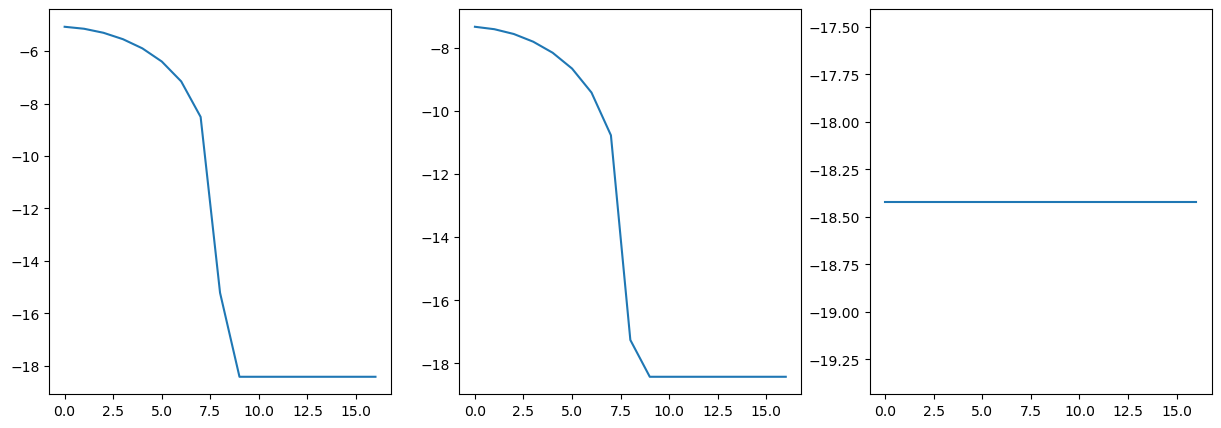

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].plot(latent_space[label_0_loc[0][0]])
ax[1].plot(latent_space[label_1_loc[0][0]])
ax[2].plot(latent_space[label_2_loc[0][0]])

572704 1368


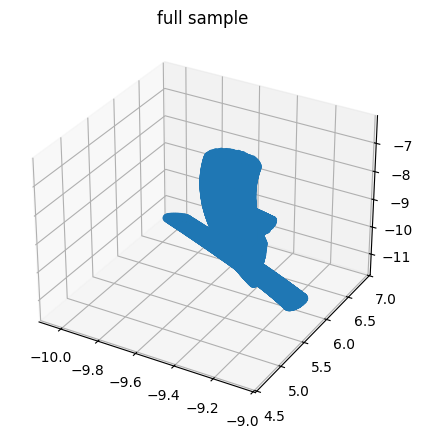

In [ ]:
from dataset.GraphDataset import CoronaryArteryDataset
import numpy as np
import matplotlib.pyplot as plt
import torch

dataset = CoronaryArteryDataset(root='data/coronary', partition=True, sub_size=1)
full_sample = dataset[0]
sample1 = dataset[0][1][0]
# sample2 = dataset[10][0][0]

def plot_3d_hex_mesh(sample, title):
    # reconstruct 3d mesh from full sample edge index
    edge_index = sample.edge_index
    mesh = sample.pos
    edge_index = edge_index.numpy()
    print(np.max(edge_index), np.min(edge_index))
    edge_index = edge_index.T
    edge_index = np.sort(edge_index, axis=1)
    edge_index = torch.tensor(edge_index).long()
    plt.figure(figsize=(15, 5))
    ax = plt.axes(projection='3d')
    ax.scatter(mesh[:, 0], mesh[:, 1], mesh[:, 2])
    # for edge in edge_index:
    #     ax.plot3D(mesh[edge, 0], mesh[edge, 1], mesh[edge, 2], 'gray')
    ax.set_title(title)



plot_3d_hex_mesh(full_sample[0][0], 'full sample')
# plot_3d_hex_mesh(sample2, 'sample 2')